<a href="https://colab.research.google.com/github/GodaBac/BachelorThesis/blob/main/Isolartion%20Forest/IsolationForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import csv
from datetime import datetime

input_file_path = '/content/drive/MyDrive/Bakalauras/duomenys.csv'

# Open the input CSV file
with open(input_file_path, 'r') as input_file:
    reader = csv.reader(input_file)

    value_names = next(reader)

    # Create an empty list to store the updated rows
    updated_rows = []

    # Loop through each row in the input file
    for row in reader:
         # Try to parse the date string as a datetime object
        try:
            date_str = row[0]
            date_obj = datetime.strptime(date_str, '%d-%m-%Y')
        except ValueError:
            # If the date string is not in the expected format, skip this row
            continue

        # Format the date object as a string in the new format
        new_date_str = date_obj.strftime('%Y-%m-%d')

        # Update the date value in the row
        row[0] = new_date_str
        # Append the updated row to the list of updated rows
        updated_rows.append(row)

# Convert the list of updated rows to a dataframe
df = pd.DataFrame(updated_rows, columns=value_names)

In [ ]:
# Convert the date column to a datetime object
df['DT'] = pd.to_datetime(df['DT'], format='%Y-%m-%d')

# Set the date column as the index of the dataframe
df.set_index('DT', inplace=True)
df['ANTAL_01'] = df['ANTAL_01'].astype(int)
df = df.iloc[::-1]

In [ ]:
model = IsolationForest()

In [ ]:
model.fit(df[['ANTAL_01']])
df['ANOMALY'] = model.predict(df[['ANTAL_01']])

In [ ]:
df.reset_index(inplace=True)


In [ ]:
df


,DT,ANTAL_01,ANOMALY
0,2015-12-31,46084,1
1,2016-01-04,46026,1
2,2016-01-05,46108,1
3,2016-01-06,45995,1
4,2016-01-07,45954,1
...,...,...,...
1813,2022-12-15,30280,-1
1814,2022-12-16,30213,-1
1815,2022-12-19,30152,-1
1816,2022-12-20,30121,-1


In [ ]:
#training and test
training = df.iloc[:-16,:]
test = df.iloc[-16:, :]
test = test.set_index('DT')

In [ ]:
import statsmodels.api as sm
model = sm.tsa.SARIMAX(training['ANTAL_01'].astype(float), exog=training['ANOMALY'], order=(1,1,1), seasonal_order=(1,0,1,22))
result = model.fit(disp=0)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [ ]:
exogTest = training.tail(22)
exogTest2 = exogTest.head(len(test))
exogTest2
exogvar = np.asarray(exogTest2['ANOMALY'])
exogvar = np.asarray(exogTest2['ANOMALY'])
exogvar
test_exog = pd.DataFrame(exogvar, index=test.index)
test_exog

,0
DT,
2022-11-30,-1
2022-12-01,-1
2022-12-02,-1
2022-12-05,-1
2022-12-06,-1
2022-12-07,-1
2022-12-08,-1
2022-12-09,-1
2022-12-12,-1


In [ ]:

# predict using SARIMAX model
pred = result.predict(start=len(training), end=len(training)+len(test)-1, exog=test_exog)

In [ ]:
pred

1802    31281.663749
1803    31512.088553
1804    31467.159114
1805    31252.500178
1806    31122.715877
1807    31101.928118
1808    31118.177354
1809    31090.217844
1810    31092.928667
1811    31094.572891
1812    31039.549022
1813    31063.238423
1814    31033.811759
1815    31027.538386
1816    31018.932842
1817    30989.501173
Name: predicted_mean, dtype: float64

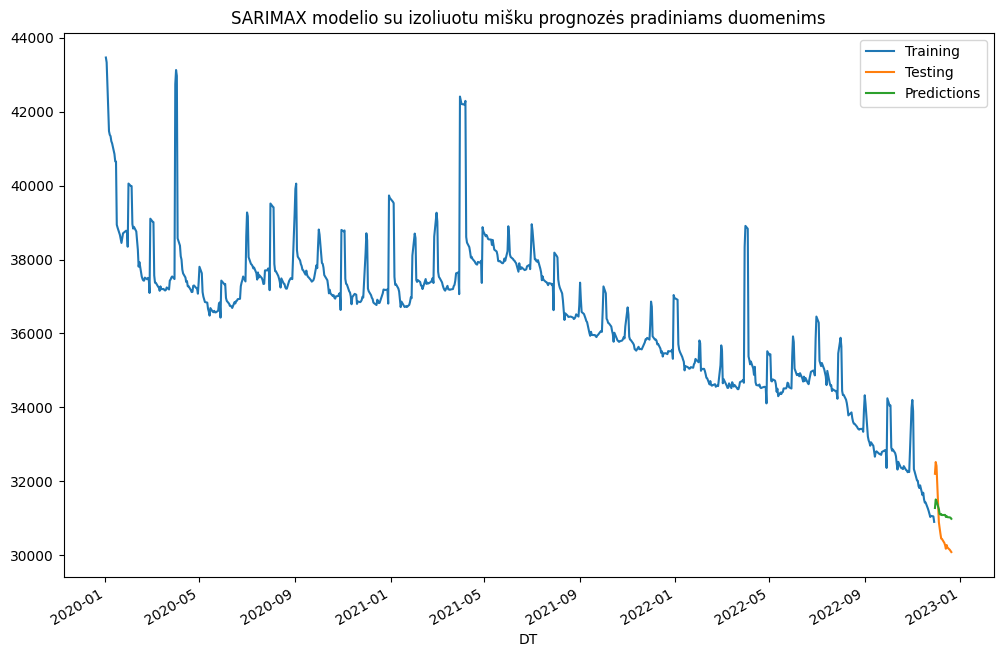

In [ ]:
predictions = pred
import matplotlib.pyplot as plt
training['ANTAL_01'].astype(float)['2020-01-01':].plot(figsize=(12, 8), label='Training')
test['ANTAL_01'].astype(float).plot(label='Testing')
pred.index = test.index
pred.plot(label='Predictions')
plt.title('SARIMAX modelio su izoliuotu mišku prognozės pradiniams duomenims')
plt.legend()